## PAGA细胞轨迹

**研究细胞分化轨迹**；另：pbmc已完全分化，因此此数仅为操作参考

1. 获取representation（降维/leiden），降维空间计算距离 --> 寻找Neighbor --> draw graph
2. （可选）sc.tl.diffmap(adata) 降噪，重新寻找Neighbor --> draw graph
3. PAGA，并且可以plot自选基因/基因集在轨迹上的表达、自定义plot热图顺序


降维聚类: Diffusion Map 在区分细胞间差异的同时，最大限度保留其连续性

### 标准流程




参考：
```
https://cloud.tencent.com/developer/article/1764757   标准流程-发育轨迹推断
https://cloud.tencent.com/developer/article/1610409   本例，详述每一步结果
https://www.jianshu.com/p/0b2ca0e0b544
https://scanpy.readthedocs.io/en/latest/api/generated/scanpy.pl.paga.html
```

In [1]:
import scanpy as sc    # the directory with the `.mtx` file
import warnings
import numpy as np
warnings.filterwarnings('ignore')

adata = sc.read_10x_mtx("./tmp/pbmc3k",var_names='gene_symbols',cache=False) 
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [2]:
def standard_process(adata):
    sc.pp.recipe_zheng17(adata)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.leiden(adata)



standard_process(adata)

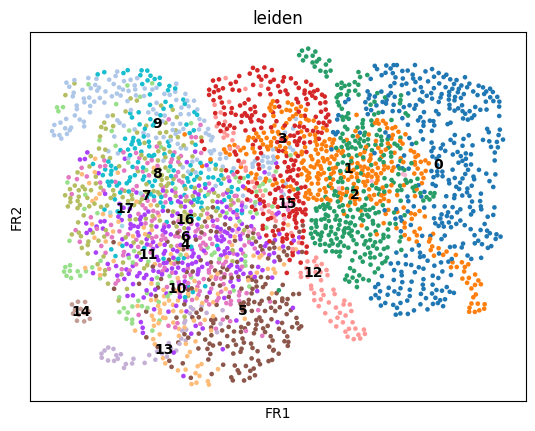

In [3]:
sc.tl.diffmap(adata)                                             ## get: obsm: ... 'X_diffmap'
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')      ## neighbors based on X_diffmap
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

<Axes: >

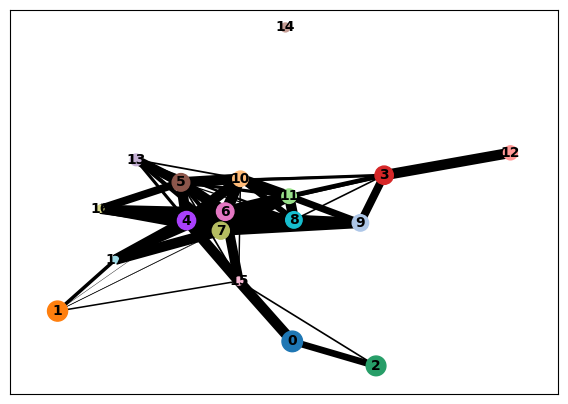

In [4]:
## PAGA & add  https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.dpt.html
sc.tl.paga(adata, groups='leiden')
adata.uns['iroot'] = 0   ## clusterID of stem cells, e.g. np.flatnonzero(adata.obs['cell_types'] == 'Stem')[0] 
sc.tl.dpt(adata)
sc.pl.paga(adata, threshold=0.03, show=False)

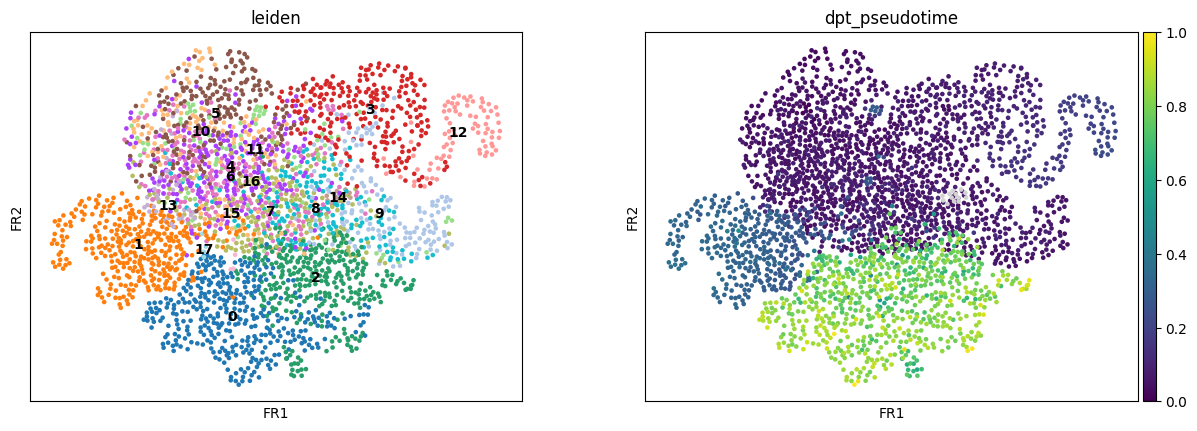

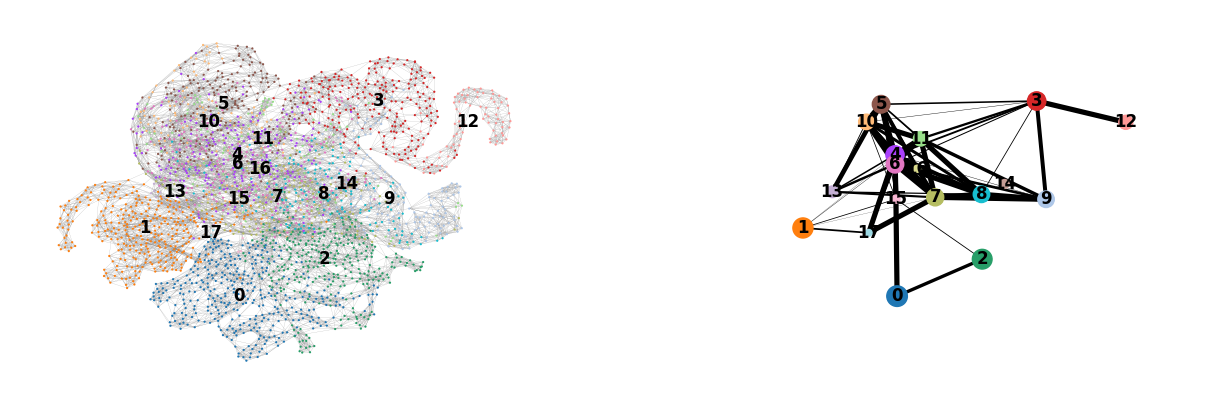

[<Axes: xlabel='FR1', ylabel='FR2'>, <Axes: >]

In [5]:
## Use1: initial graph layout with paga
sc.tl.draw_graph(adata, init_pos = 'paga')    ##  init_pos = 'X_diffmap' for layout initialization  :  paga/True/None/False/or any valid 2d-`.obsm` key
sc.pl.draw_graph(adata, color=['leiden','dpt_pseudotime'], legend_loc='on data')


## or 
sc.pl.paga_compare(adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,legend_fontsize=12, fontsize=12, edges=True, save=False)

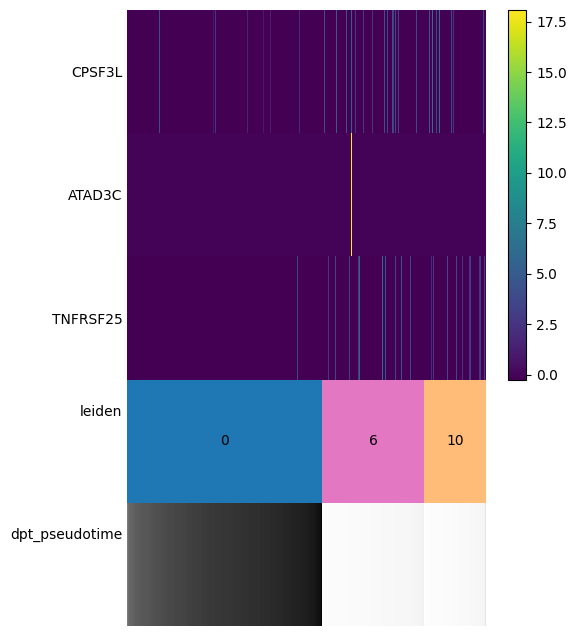

In [6]:
## Use2: 查看基因在轨迹点附近的表达：按顺序画就是轨迹表达
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['leiden'] 
#adata.uns['clusters_colors'] = np.array(adata.uns['xxx'])

sc.pl.paga_path(adata, nodes = [0,6,10], keys = adata.var_names[0:3], as_heatmap = True, return_data = False)  ## as_heatmap/return_data = True 可能会画图报错：nodes/keys的数量问题

### 使用 Seurat CLuster

不建议，因为 neighbor 需要重新选择，这样就和 原cluster 的计算不一致了

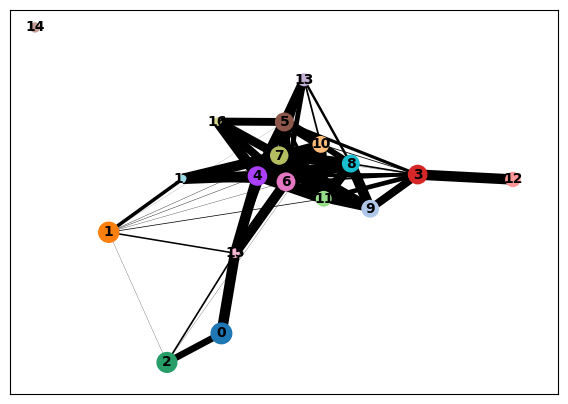

In [7]:
sc.pl.paga(adata)

In [8]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings('ignore')

adata = sc.read_h5ad("tmp/pbmc3k.h5ad")         ## sc.pl.highest_expr_genes(adata, n_top=10)
adata.obs['seurat_clusters'] =  adata.obs["seurat_clusters"].astype('category')
# adata.obs['leiden'].cat.rename_categories({'0':'New0'})

print(adata)                                

AnnData object with n_obs × n_vars = 2697 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pct.mt', 'pct.hb', 'pct.rp', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'SCT_snn_res.0.1', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'


In [9]:
sc.tl.paga(adata, groups='seurat_clusters')  ## obs: 'seurat_clusters'


print(adata.uns['paga'])
print(adata.uns['seurat_clusters_sizes'])

{'connectivities': <5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>, 'connectivities_tree': <5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>, 'groups': 'seurat_clusters'}
[1490  686  353  155   13]
